# Can you predict which NBA players will make the "All-Star" team?

## Part 1: Clean the data

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML


#### Load 'player_data' and explore the basics that you feel are relevant 

In [2]:
player_data = pd.read_csv('player_data.csv')


#### Drop the One column that you think will be useless for your use case

In [3]:
player_data.drop(columns=['Unnamed: 0'], inplace=True)

#### Drop Rows that you think will be useless for your use case

In [4]:
# Drop Rows with null values in important columns (e.g., Year, Player)
player_data = player_data.dropna(subset=['Year', 'Player'])

#### Replace null values with 0's in the '3P%' column

In [5]:
player_data['3P%'].fillna(0, inplace=True)

#### Remove rows for players who Started their careers (made their Debut) before the 1980 season

In [6]:
min_year_per_player = player_data.groupby("Player")["Year"].min()
players_to_remove = min_year_per_player[min_year_per_player < 1980].index
player_data = player_data[~player_data["Player"].isin(players_to_remove)]

In [7]:
player_data = player_data.astype({"Year": int, "Age": int})

#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

In [8]:
all_star_data = pd.read_pickle("all_star_appearances.pickle")

def create_all_star_column(row):
    player = row['Player']
    year = row['Year']
    return 1 if year in all_star_data.get(player, []) else 0

player_data['all_star'] = player_data.apply(create_all_star_column, axis=1)

In [9]:

low_per_all_star = player_data[(player_data['PER'] < 0) & (player_data['all_star'] == 1)]
print(f"Number of rows with PER < 10 and all_star = 1: {len(low_per_all_star)}")

Number of rows with PER < 10 and all_star = 1: 0


## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

In [10]:
descriptive_stats = player_data.describe()
html_table = descriptive_stats.to_html()
display(HTML(html_table))


,Year,Age,G,PER,TS%,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,WS,BPM,VORP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
count,17408.000000,17408.000000,17408.000000,17403.000000,17332.000000,17403.000000,17403.000000,17403.000000,17403.000000,17403.000000,17403.000000,17347.000000,17408.000000,17408.000000,17408.000000,17320.000000,17408.000000,17292.000000,17320.000000,16684.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000
mean,2001.659926,26.641716,48.921473,12.329667,0.502936,6.147561,13.821732,9.985600,13.016181,1.654301,1.475619,14.938012,2.344169,-2.420979,0.537655,0.436160,0.206781,0.456072,0.463653,0.719077,199.330710,106.821691,37.808709,23.547507,69.885627,470.834501,0.031882
std,9.866835,3.969742,26.677348,6.306843,0.096376,5.048217,6.629142,5.093101,9.669535,1.040907,1.857640,6.974990,2.935472,4.820625,1.332078,0.098469,0.186417,0.102074,0.100365,0.148665,199.955646,135.937581,37.366733,35.807557,65.117120,470.668694,0.175691
min,1980.000000,18.000000,1.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.100000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,24.000000,25.000000,9.600000,0.472000,2.500000,9.000000,6.000000,6.200000,1.100000,0.400000,11.200000,0.200000,-4.300000,-0.200000,0.400000,0.000000,0.421000,0.432000,0.654000,44.000000,15.000000,8.000000,3.000000,17.000000,88.000000,0.000000
50%,2002.000000,26.000000,53.000000,12.600000,0.516000,5.200000,12.800000,9.200000,10.200000,1.500000,0.900000,14.000000,1.300000,-1.900000,0.000000,0.442000,0.250000,0.466000,0.475000,0.746000,140.000000,58.000000,27.000000,11.000000,52.000000,323.000000,0.000000
75%,2010.000000,29.000000,75.000000,15.500000,0.551000,9.000000,18.100000,13.400000,17.800000,2.100000,2.000000,17.500000,3.600000,0.300000,0.800000,0.485000,0.351000,0.502000,0.511000,0.812000,288.000000,144.000000,57.000000,29.000000,106.000000,726.000000,0.000000
max,2017.000000,44.000000,85.000000,129.100000,1.136000,100.000000,100.000000,100.000000,100.000000,24.200000,77.800000,100.000000,21.200000,36.200000,12.400000,1.000000,1.000000,1.000000,1.500000,1.000000,1530.000000,1164.000000,301.000000,456.000000,464.000000,3041.000000,1.000000


#### Graph the distibution of the 'Age' feature. What conclusion can you reach from this?

##### General distribution of Age

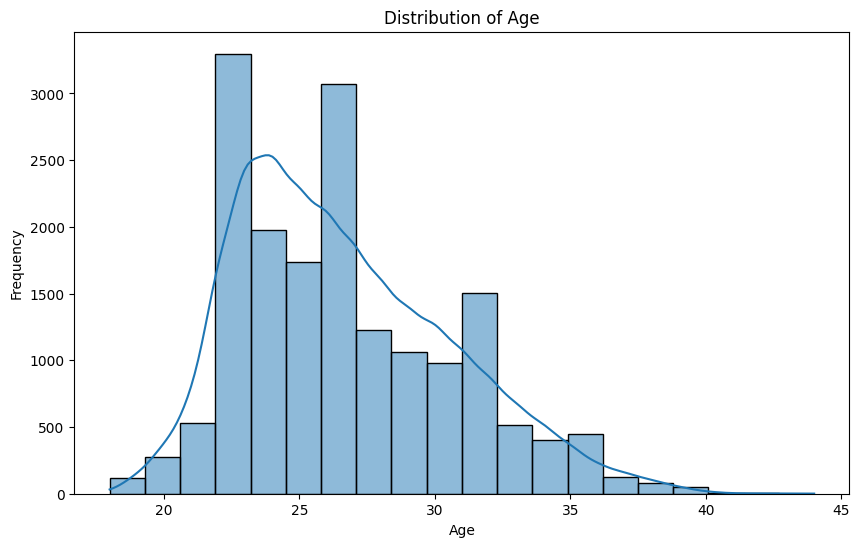

In [11]:
plt.figure(figsize=(10, 6))
hist_data = sns.histplot(player_data['Age'], bins=20, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


##### Distribution of Age for All-Star players for each decade

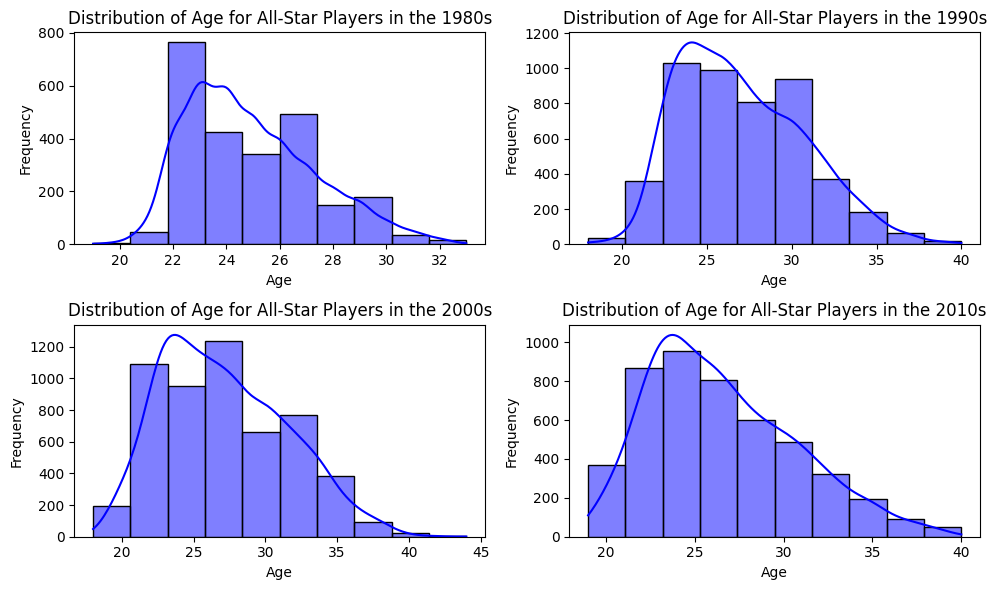

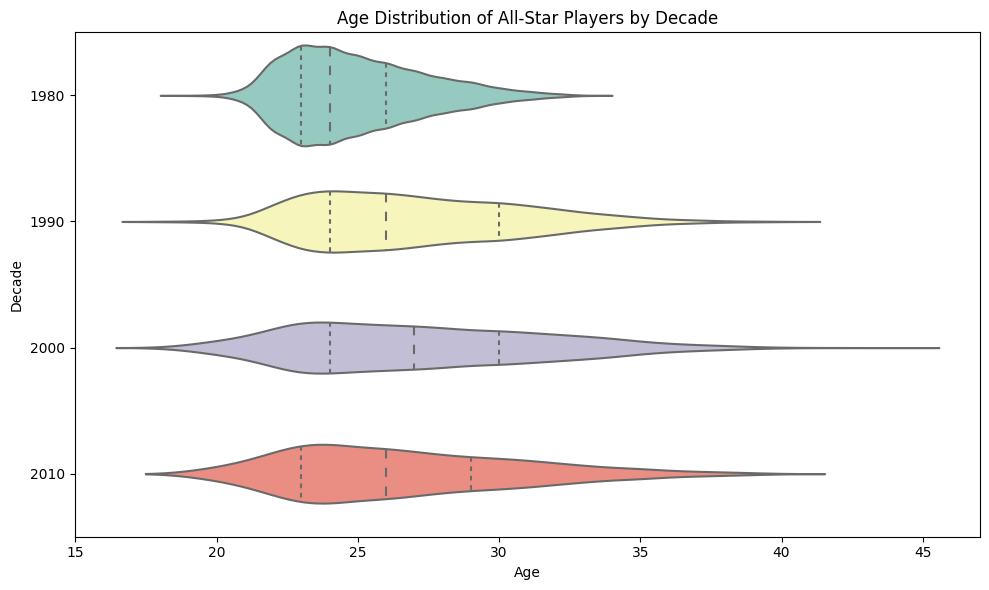

In [12]:
# Create subplots for age distribution of All-Star players in each decade
plt.figure(figsize=(10, 6))
decades = [1980, 1990, 2000, 2010]

for i, decade in enumerate(decades):
    plt.subplot(2, 2, i+1)
    sns.histplot(
        player_data[(player_data['Year'] // 10 == decade // 10)]['Age'],
        bins=10, kde=True, color="blue"
    )
    plt.title(f"Distribution of Age for All-Star Players in the {decade}s")
    plt.xlabel("Age")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Add a 'Decade' column to the data and create a violin plot
player_data['Decade'] = (player_data['Year'] // 10) * 10

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=player_data,
    y='Decade', 
    x='Age', 
    palette='Set3', 
    inner='quartile',
    orient='h'
)

plt.title("Age Distribution of All-Star Players by Decade")
plt.xlabel("Age")
plt.ylabel("Decade")
plt.tight_layout()
plt.show()

##### Distribution of Age for All-Star players

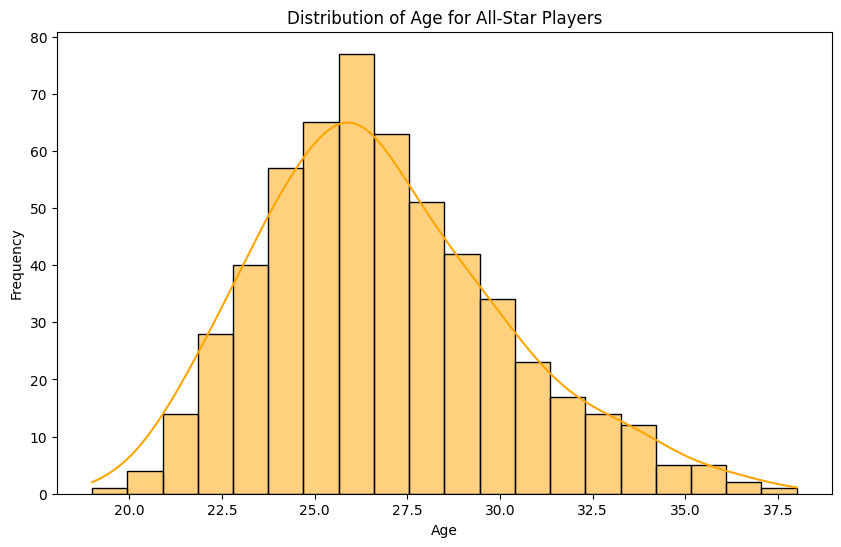

In [13]:
plt.figure(figsize=(10, 6))
hist_data = sns.histplot(player_data[player_data['all_star'] == 1]['Age'], bins=20, kde=True, color='orange')
plt.title("Distribution of Age for All-Star Players")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


##### Distribution of Age for All-Star players for each decade

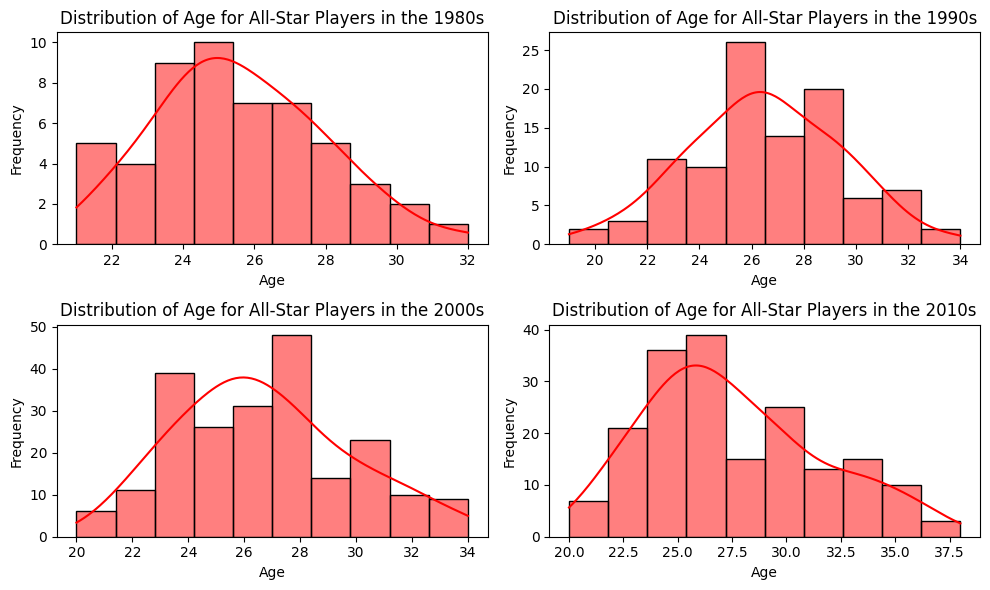

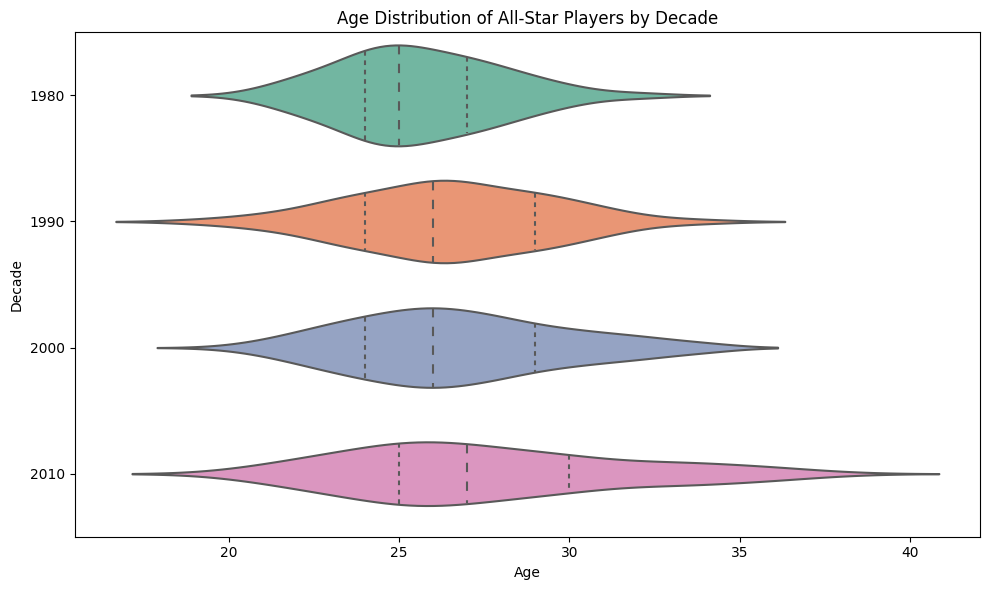

In [14]:
# Create subplots for age distribution of All-Star players in each decade
plt.figure(figsize=(10, 6))
decades = [1980, 1990, 2000, 2010]

for i, decade in enumerate(decades):
    plt.subplot(2, 2, i+1)
    sns.histplot(
        player_data[(player_data['Year'] // 10 == decade // 10) & (player_data['all_star'] == 1)]['Age'],
        bins=10, kde=True, color="red"
    )
    plt.title(f"Distribution of Age for All-Star Players in the {decade}s")
    plt.xlabel("Age")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Add a 'Decade' column to the data and create a violin plot
player_data['Decade'] = (player_data['Year'] // 10) * 10

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=player_data[player_data['all_star'] == 1],
    y='Decade', 
    x='Age', 
    palette='Set2', 
    inner='quartile',
    orient='h'
)

plt.title("Age Distribution of All-Star Players by Decade")
plt.xlabel("Age")
plt.ylabel("Decade")
plt.tight_layout()
plt.show()

#### Create a correlation map of the features

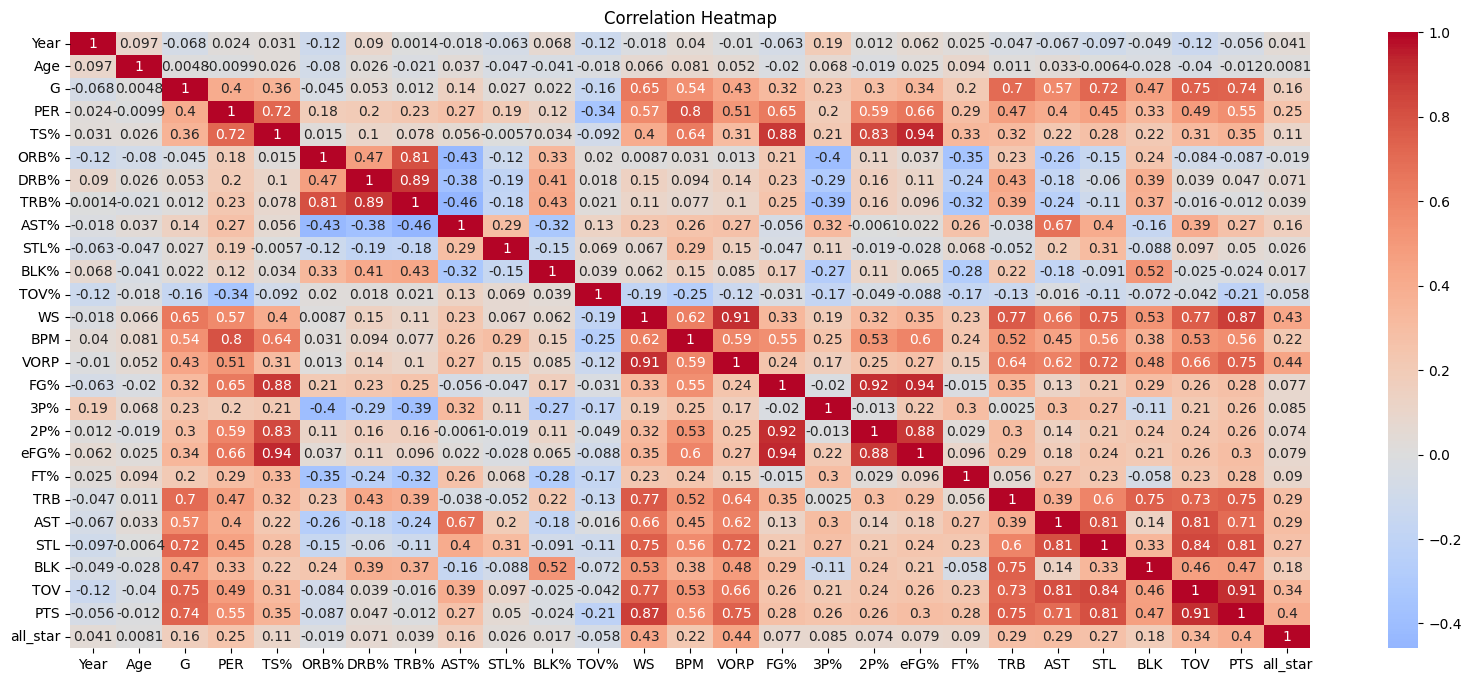

In [15]:
numeric_columns = player_data.drop(columns=['Decade']).select_dtypes(include=[np.number]).columns
correlation_matrix = player_data[numeric_columns].corr()

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

#### Remove Features that you consider to be too correlated or "duplicated"

When considering which players will become All-Stars in the upcoming year, it is essential to choose variables that are relevant and informative for this prediction task. Here are a description on which variables to keep and which ones to consider removing:

**Variables to Keep or Consider:**

1. **Year**: This variable is useful for filtering the data and ensuring that information from previous seasons is used to predict the next year's All-Stars.

2. **Age**: A player's age can influence their performance and the likelihood of being selected as an All-Star.

3. **G**: The number of games a player participated in during the current season can be an important metric for their All-Star selection.

4. **PER**: The Player Efficiency Rating is a metric that reflects a player's overall performance. It can be a useful indicator for predicting All-Star selection.

5. **TS%**: A player's shooting efficiency can be a significant factor in their selection as an All-Star.

6. **ORB%, DRB%, TRB%**: These rebounding metrics can indicate a player's ability to dominate the boards, which may influence their All-Star selection.

7. **AST%**: A player's assist rate can reflect their ability to create opportunities for teammates and contribute to team success.

**Variables to Consider Removing:**

1. **BPM** and **VORP**: These metrics are derived and may be correlated with other variables, such as PER. Considering removing one of them to avoid multicollinearity.

2. **FG%, 3P%, 2P%, eFG%**: These shooting metrics may overlap with the more comprehensive shooting efficiency metric (TS%). You might choose to keep the broader metric (TS%) and remove the others.

3. **BLK%**, **STL%**, **TOV%**: While important, these metrics may not be as decisive for All-Star selection as other variables.

4. **FT%**: Free throw percentage is relevant, but not as comprehensive as TS%, which already includes all types of shots.


In [16]:
columns_to_remove = ['BPM', 'VORP', 'FG%', '3P%', '2P%', 'eFG%', 'BLK%', 'STL%', 'TOV%', 'FT%']
player_data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

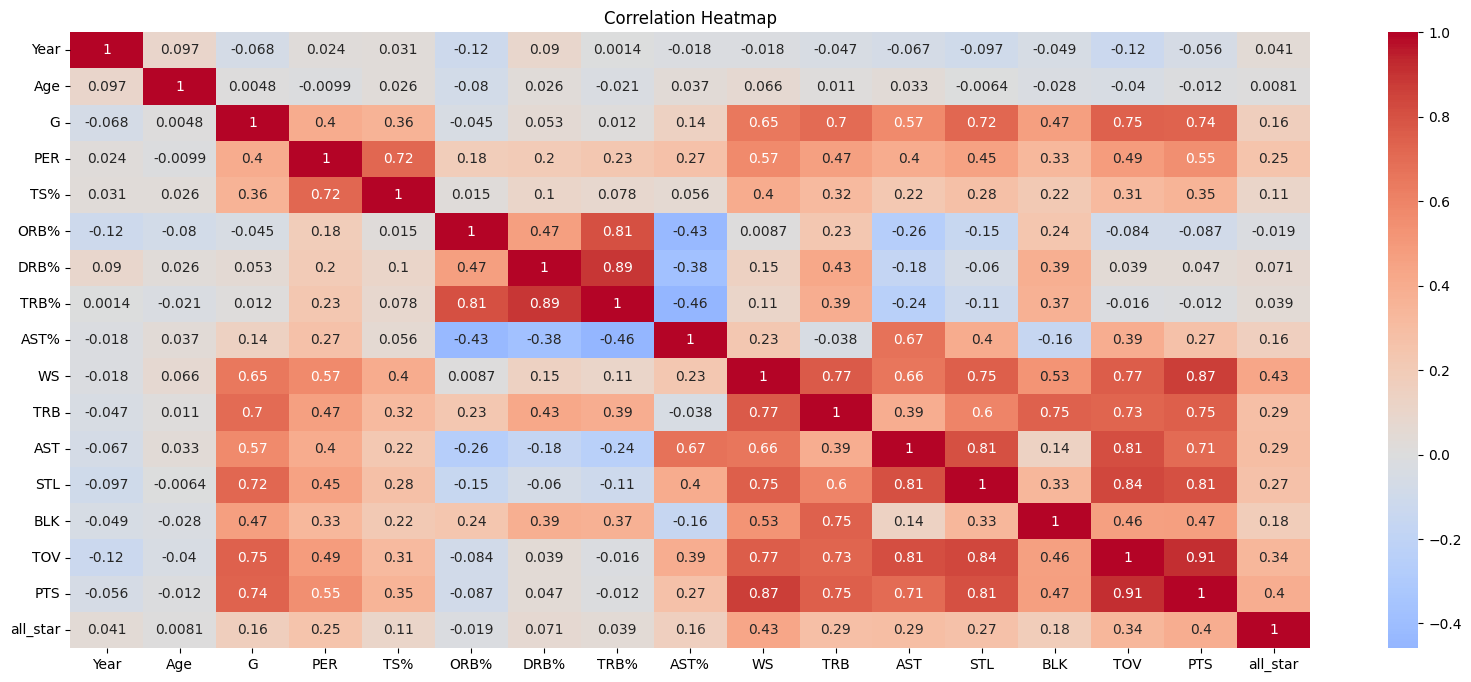

In [17]:
numeric_columns = player_data.drop(columns=['Decade']).select_dtypes(include=[np.number]).columns
correlation_matrix = player_data[numeric_columns].corr()

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
threshold = 0.7
upper_triangular = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1) == 1)
to_drop = [column for column in upper_triangular.columns if any(upper_triangular[column] > threshold)]
player_data.drop(columns=to_drop, inplace=True)

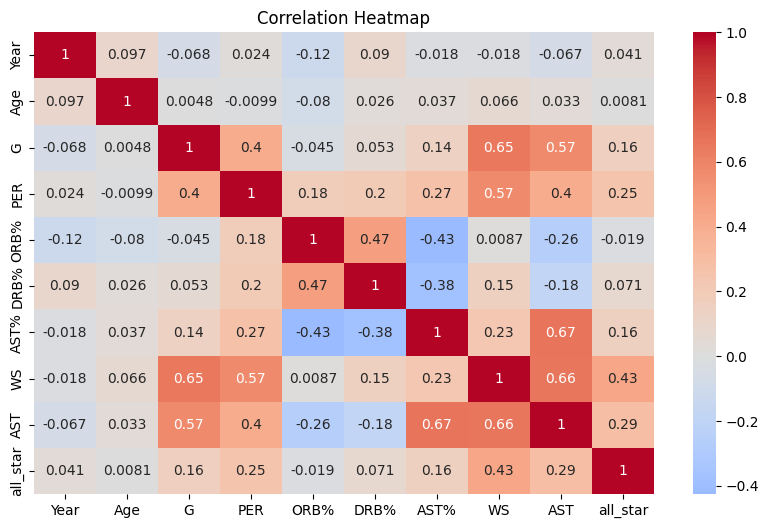

In [19]:
numeric_columns = player_data.drop(columns=['Decade']).select_dtypes(include=[np.number]).columns
correlation_matrix = player_data[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

## Part 3: Modeling

#### Build a simple classifier that predicts whether or not a player makes an All-Star team based on their stats for that season.

Precision: 0.6923076923076923
Recall: 0.20610687022900764


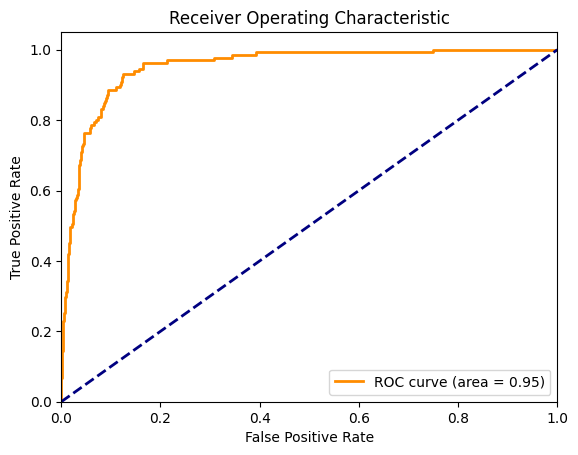

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib

# Separate features and target
X = player_data.drop(columns=['all_star', 'Player', 'Tm', 'Pos'])
y = player_data['all_star']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train_scaled, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)

# Calculate ROC curve and AUC
y_scores = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


##### Save the trained model to a file

In [21]:

model_filename = 'logistic_regression_model.pkl'
joblib.dump(model, model_filename)
print("Model saved as", model_filename)


Model saved as logistic_regression_model.pkl


## Part 4: Data Engineering

#### Imagine that we are in 2017 and we collect this data from each of the 31 teams that play on the NBA. Each one of the teams exposes a REST API endpoint for us to extract the data and process it, this means that we have to do 31 different GET requests on each update. We are building a Web Application for ESPN and they need this data to be updated on daily basis, so when sports analysts start working in the morning they have fresh stats to go over and can give informed predictions in TV about which players will be making the All-Star team. We have an approximate of 12 users that will be using the product on daily basis.

#### At the end of each season, we will update the Pickle file (which is stored in a Bucket in Cloud Object Storage) to include the players that were included in the All-Star team and keep the dataset and model updated. All the development will be done in Python, and the architecture of the ETL process will be defined by you, along with the Cloud Service Provider (you can choose between AWS, GCP, Azure). Don't worry about the Backend and Frontend of the App, that will be defined and implemented by the Development team, but they are waiting on your decision on which database to use.

#### Would you use a dedicated server or a serverless architecture? Why?

>For this scenario, a serverless architecture would be a more suitable choice. Here's why:
>
>1. **Scalability**: Serverless architectures can automatically scale up or down based on demand. Since you need to perform 31 GET requests daily, the workload might vary depending on the time of the day and the season. A serverless architecture can handle this variability efficiently by automatically provisioning the necessary resources without manual intervention.
>
>2. **Cost Efficiency**: With a dedicated server, you would need to provision resources based on the peak demand, which might result in over-provisioning during off-peak hours. Serverless, on the other hand, charges you based on the actual usage, making it cost-effective, especially when you have varying workloads.
>
>3. **Maintenance**: Serverless platforms handle infrastructure management, updates, and scaling automatically. This frees you from the operational overhead of managing a dedicated server, allowing you to focus more on the development of the ETL process.
>
>4. **Quick Deployment**: Serverless architectures allow for rapid development and deployment. Since you're building a daily data update process, a serverless approach can enable you to iterate and deploy changes quickly.
>
>5. **Developer Focus**: With a serverless approach, developers can concentrate on writing code and designing the ETL process without worrying about server setup, networking, or provisioning.
>
>6. **Cost Predictability**: For a daily process like this, a serverless architecture can offer better cost predictability. You only pay for the resources used during the execution of your functions.
>
>Given these advantages, a serverless architecture, such as AWS Lambda, would be a more efficient and cost-effective choice for this data update process.


#### What Computing resources would you use? Why?

>For this scenario, my choice would be AWS Lambda, scheduled through AWS CloudWatch. This decision is grounded in the following reasons:
>
>- **Scalability**: AWS Lambda allows auto-scaling, seamlessly adjusting resources as the workload fluctuates. With 31 daily GET requests from NBA team APIs, >this ensures efficient handling of varying demand.
>
>- **Cost Efficiency**: The pay-as-you-go model of Lambda aligns with the need to process daily updates. Costs are optimized, especially compared to >provisioning dedicated servers.
>
>- **Timely Updates**: By leveraging AWS CloudWatch, scheduled Lambda functions can execute precisely when sports analysts start their day, guaranteeing >fresh statistics for informed predictions.
>
>However, if an orchestration tool like Apache Airflow is already in place, it can offer an alternative. Airflow's capabilities for process management and >scheduling could be integrated with Lambda for enhanced orchestration.
>
>In summary, the combination of AWS Lambda and CloudWatch provides the scalability, cost-efficiency, and timely updates required for this data update >scenario. If Apache Airflow is available, it could also be considered for seamless orchestration.
>

#### What type of storage would you choose? How would you guarantee data quality and consistency?

>I would choose Amazon S3 as the storage solution due to its scalability, durability, and integration capabilities. To ensure data quality and consistency, I >would implement the following measures:
>
>1. **Delta Lake:** I would utilize Delta Lake, a storage layer that brings ACID transactions to S3. Delta Lake's versioning and schema enforcement features >would help maintain data consistency over time.
>
>2. **Data Validation:** Before ingestion, data validation checks would be performed to identify and rectify any anomalies or errors, ensuring only accurate >data enters the storage layer.
>
>3. **Schema Evolution Control:** Delta Lake's schema evolution control would help manage changes to the data structure while maintaining consistency, >preventing data quality issues.
>
>4. **Atomic Writes:** Leveraging Delta Lake's atomic write operations, updates to the dataset would be transactional. This guarantees that either the entire >update succeeds or fails, preventing partial or inconsistent updates.
>
>5. **Historical Tracking:** Delta Lake's versioning allows historical tracking of changes, enabling the ability to revert to previous states and ensuring >data consistency even if issues arise.
>
>By combining Amazon S3's scalability with Delta Lake's features, we can secure data quality and consistency throughout the data update process.


#### What Security considerations would you implement for these architecture?

>For the architecture involving AWS Lambda scheduled by CloudWatch, making GET requests to third-party APIs, checking data quality, and storing it in a Delta >table on S3:
>
>1. **Secure Communication:** Use HTTPS for API requests to ensure encrypted data transfer.
>
>2. **Credential Protection:** Safeguard API credentials within AWS Secrets Manager.
>
>3. **Access Control:** Apply strict IAM roles to limit permissions for Lambda functions.
>
>4. **Data Validation:** Validate incoming API data for quality and consistency.
>
>By prioritizing secure communication, credential protection, access control, and data validation, the architecture ensures the safety and integrity of the data handling process.
>

#### What type of monitoring, costs analysis and application performance should this architecture have?

>1. **Monitoring**: Implement CloudWatch Logs and Metrics to track Lambda function executions, API responses, and data processing.
>
>2. **Cost Analysis**: Utilize AWS Cost Explorer to analyze Lambda and storage costs. Set up budget alerts for cost control.
>
>3. **Performance**: Monitor Lambda execution time and API response times. Use CloudWatch Alarms to detect anomalies.
>
>By establishing robust monitoring, cost analysis, and performance tracking, the architecture ensures efficient operations, cost control, and optimal >performance.

#### Please do a simple sketch of the Architecture for this application and explain it in a brief paragraph (you can keep it simple, don't worry too much about the design)

![Architecture](design.png)

>Explanation:
>
>* **CloudWatch Scheduler**: This triggers scheduled AWS Lambda functions. At a specified time, it initiates Lambda executions to retrieve data from the 31 external API endpoints.
>
>* **AWS Lambda**: These functions perform GET requests to the external API endpoints, check data quality, and process the retrieved data. They then save the validated data into a Delta Table stored in an S3 bucket.
>
>* **External API Endpoints**: These are the REST APIs exposed by each NBA team. The Lambda functions interact with them to gather player statistics.
>
>* **Delta Table (S3 Storage)**: The validated and processed data is stored in a Delta Table format in an S3 bucket. This format allows for versioning, data consistency, and efficient querying.
>
>This architecture ensures that data is fetched, validated, and stored reliably, ready for further analysis and predictions.
